## Los datos
- Grupo
- Sexo
- Edad
- Modo_Llegada
- Lesión
- Queja_Principal
- Estado_Mental
- Dolor
- Dolor_NRS
- SBP
- DBP
- HR
- RR
- BT
- Saturación
- KTAS_Enfermera
- Diagnóstico_Urgencias
- Disposición
- KTAS_Experto
- Grupo_Error
- Duración_Estancia_Min
- Duración_KTAS_Min
- Error_Triaje


In [98]:
import numpy as np
import pandas as pd

from joblib import dump, load

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer

import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
import re, string, unicodedata

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import nltk

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats
import scipy.optimize as optimize

In [99]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jorgi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jorgi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jorgi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1. Carga de los datos

In [101]:
datos = pd.read_csv("./data/Regresión_train_data.csv")

In [102]:
datos.shape

(1000, 23)

In [103]:
datos.dtypes

Grupo                         int64
Sexo                          int64
Edad                          int64
Modo_Llegada                  int64
Lesion                        int64
Queja_Principal              object
Estado_Mental                 int64
Dolor                         int64
dolor_NRS                    object
SBP                         float64
DBP                         float64
HR                          float64
RR                          float64
BT                          float64
Saturacion                  float64
KTAS_enfermera                int64
Diagnostico_En_Urgencias     object
Disposicion                   int64
KTAS_experto                  int64
Grupo_De_Error                int64
Duracion_Estancia_Min         int64
Duracion_KTAS_Min            object
Error_Triaje                  int64
dtype: object

In [104]:
datos.sample(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,BT,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje
886,2,1,62,3,1,ant. chest pain,1,1,3,150.0,...,37.4,98.0,2,"Pneumonia, unspecified",1,2,0,607,"5,00",0
60,2,2,69,2,1,epistaxis,1,0,#BOÞ!,140.0,...,36.1,96.0,3,Epistaxis,1,3,0,196,"5,00",0
20,1,2,78,3,1,dizziness,1,0,#BOÞ!,132.0,...,36.8,NaN,3,Dizziness,1,3,0,129,"5,38",0
439,2,1,70,2,1,dyspnea,2,1,3,NaN,...,36.3,78.0,2,Dyspnoea,6,1,1,593,"2,00",2
978,2,1,75,3,1,ant. chest pain,1,1,6,110.0,...,36.1,98.0,2,Ischaemic chest pain,2,2,0,19523,"2,00",0


## 2. Entendimiento de los datos

Variables numericas candidatas a utilizar

In [107]:
candidatas = ["Edad","Disposicion","KTAS_experto","Duracion_KTAS_Min","EWS"]
numericas=["Grupo", "Sexo", "Edad", "Modo_Llegada", "Lesion", "Estado_Mental", "Dolor", "dolor_NRS", "KTAS_enfermera", "Disposicion", "KTAS_experto", "Duracion_Estancia_Min", "Duracion_KTAS_Min"]

In [108]:
datos.describe()

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,Saturacion,KTAS_enfermera,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Error_Triaje
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,983.000000,979.000000,988.000000,985.000000,989.000000,444.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.450000,1.514000,53.892000,2.811000,1.2000,1.103000,0.562000,133.485249,79.566905,84.400810,19.450761,36.562993,97.047297,3.328000,1.610000,3.260000,0.569000,12792.480000,0.253000
std,0.497743,0.500054,19.826483,0.796186,0.4002,0.431946,0.496389,27.156136,15.174593,16.297428,2.069882,0.519699,4.761112,0.862067,1.161572,0.865534,1.587375,87721.151446,0.630387
min,1.000000,1.000000,16.000000,1.000000,1.0000,1.000000,0.000000,50.000000,31.000000,32.000000,14.000000,35.000000,20.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,36.000000,2.000000,1.0000,1.000000,0.000000,114.000000,70.000000,73.000000,18.000000,36.200000,97.000000,3.000000,1.000000,3.000000,0.000000,132.750000,0.000000
50%,1.000000,2.000000,56.000000,3.000000,1.0000,1.000000,1.000000,130.000000,80.000000,82.000000,20.000000,36.500000,98.000000,3.000000,1.000000,3.000000,0.000000,270.500000,0.000000
75%,2.000000,2.000000,70.250000,3.000000,1.0000,1.000000,1.000000,150.000000,90.000000,96.000000,20.000000,36.800000,99.000000,4.000000,2.000000,4.000000,0.000000,620.000000,0.000000
max,2.000000,2.000000,94.000000,7.000000,2.0000,4.000000,1.000000,275.000000,160.000000,148.000000,30.000000,39.800000,100.000000,5.000000,7.000000,5.000000,9.000000,709510.000000,2.000000


In [109]:
datos["Sexo"].value_counts()


Sexo
2    514
1    486
Name: count, dtype: int64

In [110]:
datos["dolor_NRS"].value_counts()

dolor_NRS
#BOÞ!    440
3        209
4        111
5        109
6         59
2         31
7         27
8          8
10         3
1          2
9          1
Name: count, dtype: int64

In [111]:
datos["Error_Triaje"].value_counts()

Error_Triaje
0    851
2    104
1     45
Name: count, dtype: int64

In [112]:
datos["Modo_Llegada"].value_counts()

Modo_Llegada
3    588
2    220
4    122
1     60
6      7
5      2
7      1
Name: count, dtype: int64

In [113]:
datos["Grupo_De_Error"].value_counts().sort_index()


Grupo_De_Error
0    851
1     16
2     39
3      6
4     50
5     11
6      6
7      7
8      9
9      5
Name: count, dtype: int64

In [114]:
datos["Queja_Principal"].value_counts().sort_index()

Queja_Principal
??                       5
?? ??                    1
?? ???                   2
?? ??? ??                1
???                      3
                        ..
weakness                 1
whirling type vertigo    3
wrist laceration         1
wrist pain, Lt           1
wrist pain, Rt           1
Name: count, Length: 347, dtype: int64

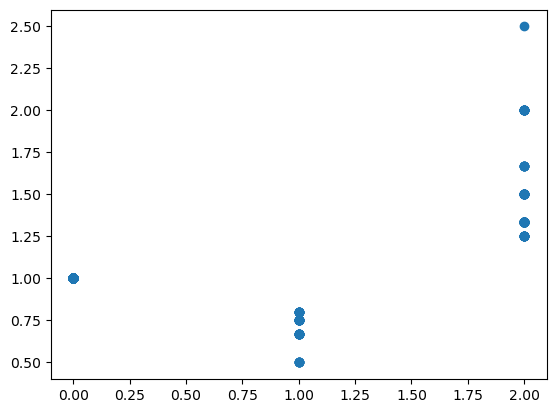

In [115]:
datos[["KTAS_enfermera","KTAS_experto","Error_Triaje"]]
a = datos[datos["KTAS_enfermera"]!=datos["KTAS_experto"]][["KTAS_enfermera","KTAS_experto","Error_Triaje"]]
a[a["Error_Triaje"]==1]
plt.scatter(datos["Error_Triaje"], datos["KTAS_enfermera"]/datos["KTAS_experto"])


In [116]:
def calcularEWS(registro):
    total = 0
    
    # Frecuencia respiratoria (RR)
    if registro['RR'] <= 8:
        total += 2
    elif 9 <= registro['RR'] <= 14:
        total += 0
    elif 15 <= registro['RR'] <= 20:
        total += 1
    elif 21 <= registro['RR'] <= 29:
        total += 2
    elif registro['RR'] >= 30:
        total += 3
    
    # Presión arterial sistólica (SBP)
    if registro['SBP'] <= 70:
        total += 3
    elif 71 <= registro['SBP'] <= 80:
        total += 2
    elif 81 <= registro['SBP'] <= 100:
        total += 1
    elif 101 <= registro['SBP'] <= 199:
        total += 0
    elif registro['SBP'] >= 200:
        total += 2

    # Frecuencia cardíaca (HR)
    if registro['HR'] <= 40:
        total += 2
    elif 41 <= registro['HR'] <= 50:
        total += 1
    elif 51 <= registro['HR'] <= 100:
        total += 0
    elif 101 <= registro['HR'] <= 110:
        total += 1
    elif 111 <= registro['HR'] <= 129:
        total += 2
    elif registro['HR'] >= 130:
        total += 3

    # Temperatura corporal (BT)
    if registro['BT'] < 35.0:
        total += 2
    elif 35.0 <= registro['BT'] <= 38.4:
        total += 0
    elif 38.5 <= registro['BT']:
        total += 2

    # Saturación de oxígeno (Saturacion)
    if registro['Saturacion'] <= 91:
        total += 3
    elif 92 <= registro['Saturacion'] <= 93:
        total += 2
    elif 94 <= registro['Saturacion'] <= 95:
        total += 1

    # Nivel de conciencia
    if registro['Estado_Mental'] == 1:
        total += 0
    elif registro['Estado_Mental'] == 2:
        total += 1
    elif registro['Estado_Mental'] == 3:
        total += 2
    elif registro['Estado_Mental'] == 4:
        total += 3
    return total

datos['EWS'] = datos.apply(calcularEWS, axis=1)
print(datos.head())

   Grupo  Sexo  Edad  Modo_Llegada  Lesion  Queja_Principal  Estado_Mental  \
0      2     2    49             2       1  ant. chest pain              1   
1      2     2    30             4       1         headache              1   
2      2     1    61             3       2  ant. chest pain              1   
3      2     2    61             3       1         headache              1   
4      1     2    67             3       1    fever & chill              1   

   Dolor dolor_NRS    SBP  ...  Saturacion  KTAS_enfermera  \
0      1         2  150.0  ...        98.0               2   
1      1         4  140.0  ...        99.0               3   
2      1         3  100.0  ...        98.0               4   
3      1         4  120.0  ...        99.0               4   
4      0     #BOÞ!  143.0  ...         NaN               4   

                Diagnostico_En_Urgencias  Disposicion  KTAS_experto  \
0                   Ischaemic chest pain            2             2   
1  Subarachnoid 

In [117]:
datos.sample(10)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS
7,2,1,58,4,2,post-CPR state,4,0,#BOÞ!,140.0,...,90.0,1,Cardiac arrest with successful resuscitation,2,1,0,1010,"2,00",0,8
393,1,1,53,3,1,epigastric pain,1,1,4,156.0,...,NaN,4,Epigastric pain,1,3,2,132,"4,13",2,1
496,1,1,82,6,1,perm cath. malfunction,1,0,#BOÞ!,130.0,...,NaN,4,Percutaneous catheter problem,1,4,0,0,"5,00",0,1
398,1,1,69,1,1,"Discomfort, Chest",1,1,2,106.0,...,NaN,2,Acute coronary syndrome,2,2,0,233,"10,23",0,1
926,2,2,21,3,1,dyspnea,1,0,#BOÞ!,130.0,...,92.0,3,Other specified interstitial pulmonary diseases,2,3,0,625,"3,00",0,4
299,1,1,47,2,2,facial injury,1,1,4,93.0,...,NaN,4,Injury of face,1,4,0,132,"5,65",0,2
445,2,2,58,3,1,ant. chest pain,1,1,3,160.0,...,98.0,2,Unstable angina,1,2,0,443,"3,00",0,1
328,1,2,66,2,1,HA,1,1,3,150.0,...,NaN,4,Headache,1,4,0,32,"3,32",0,1
284,2,1,60,3,2,Open Wound,1,1,3,120.0,...,98.0,4,"Open wound of other parts of head, face",1,4,0,7979,"3,00",0,1
486,1,2,48,4,1,abd pain,1,1,5,166.0,...,NaN,3,Acute pancreatitis,2,3,0,339,"5,87",0,2


Análisis de completitud

In [119]:
datos.isnull().sum() / datos.shape[0]

Grupo                       0.000
Sexo                        0.000
Edad                        0.000
Modo_Llegada                0.000
Lesion                      0.000
Queja_Principal             0.000
Estado_Mental               0.000
Dolor                       0.000
dolor_NRS                   0.000
SBP                         0.017
DBP                         0.021
HR                          0.012
RR                          0.015
BT                          0.011
Saturacion                  0.556
KTAS_enfermera              0.000
Diagnostico_En_Urgencias    0.001
Disposicion                 0.000
KTAS_experto                0.000
Grupo_De_Error              0.000
Duracion_Estancia_Min       0.000
Duracion_KTAS_Min           0.000
Error_Triaje                0.000
EWS                         0.000
dtype: float64

### 2.1. Búsqueda de relaciones con la variable objetivo

Si se logra visualizar o cuantificar altas correlaciones entre las variables de entrada y la variable objetivo, se podrán soportar las decisiones del experto con base en la evidencia.

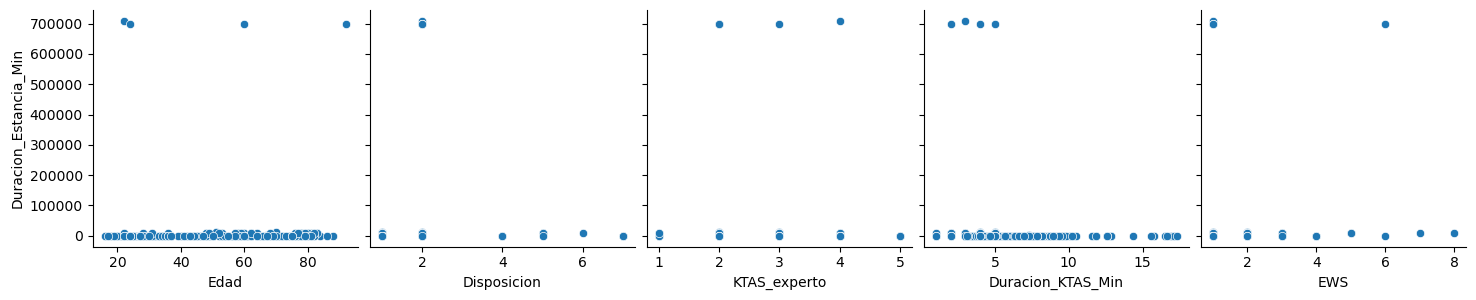

In [121]:
datos["Duracion_KTAS_Min"] = datos["Duracion_KTAS_Min"].str.replace(',', '.').astype('float64')
sns.pairplot(datos.sample(frac=0.2), height=3, y_vars="Duracion_Estancia_Min", x_vars=candidatas, kind="scatter")

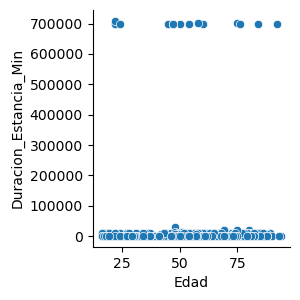

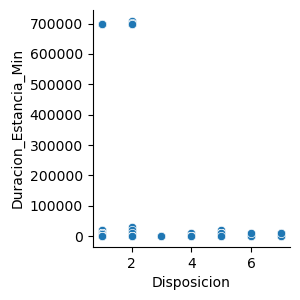

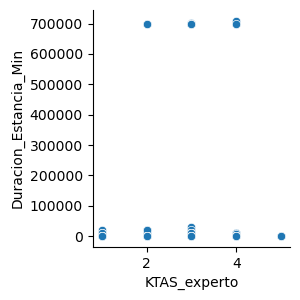

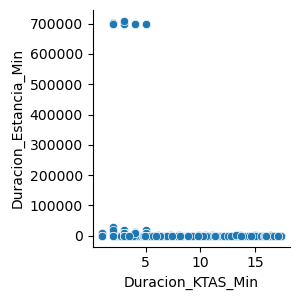

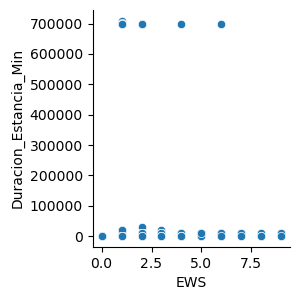

In [122]:
for variable in candidatas:
    sns.pairplot(datos, height=3, y_vars="Duracion_Estancia_Min", x_vars=variable, kind="scatter")

In [123]:
datos["Modo_Llegada"] = datos["Modo_Llegada"].apply(lambda x: 1 if x == 1 else (2 if x == 2 or x ==4 else (3 if x == 3 else 4)))


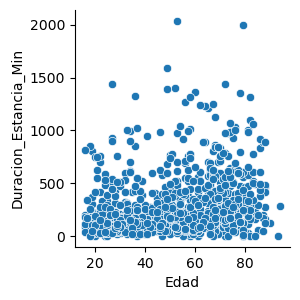

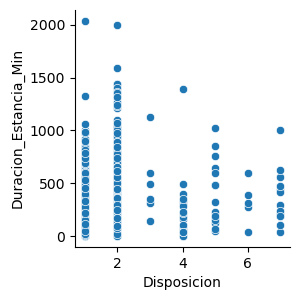

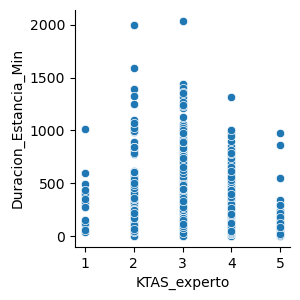

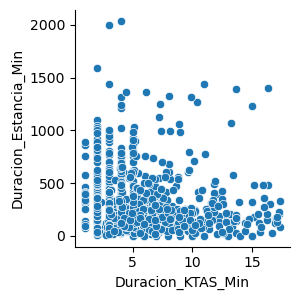

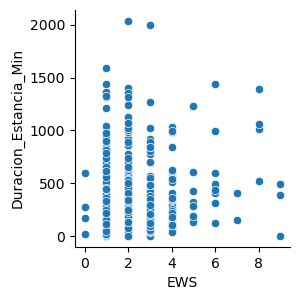

In [124]:
prueba=datos[datos["Duracion_Estancia_Min"]<=4000]
for variable in candidatas:
    sns.pairplot(prueba, height=3, y_vars="Duracion_Estancia_Min", x_vars=variable, kind="scatter")

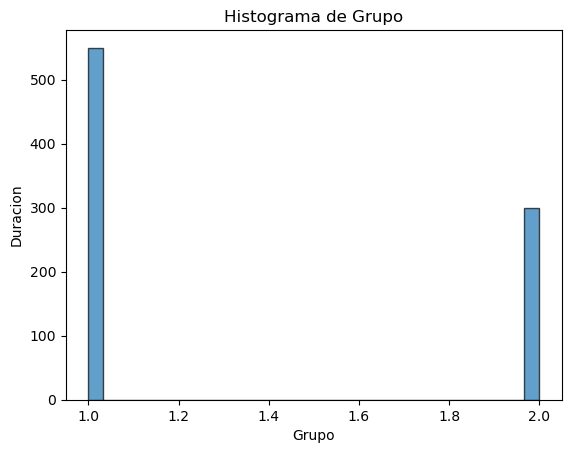

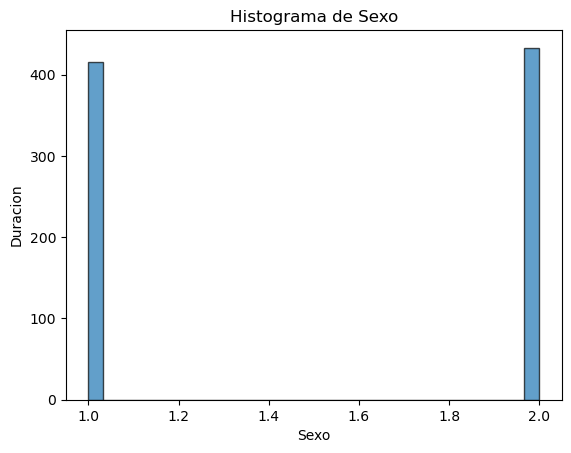

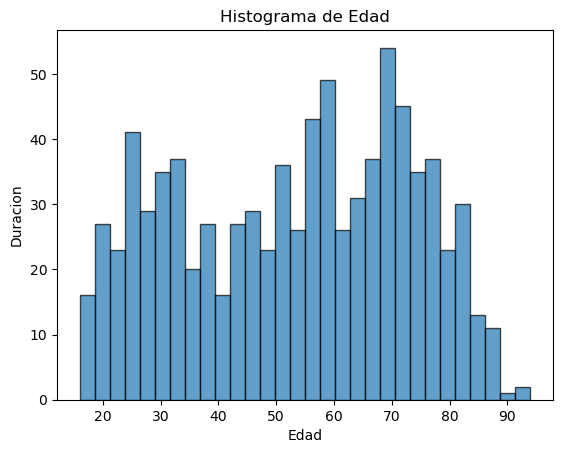

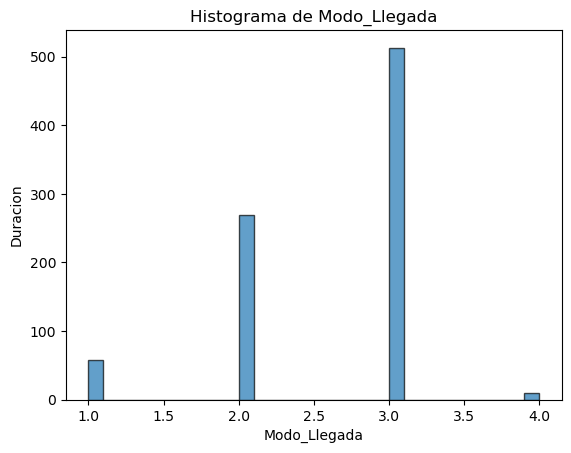

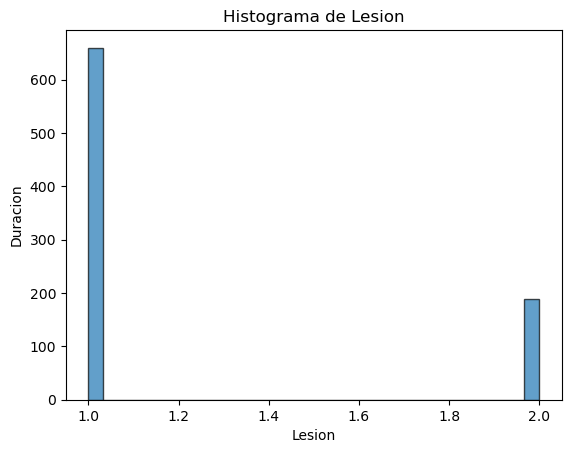

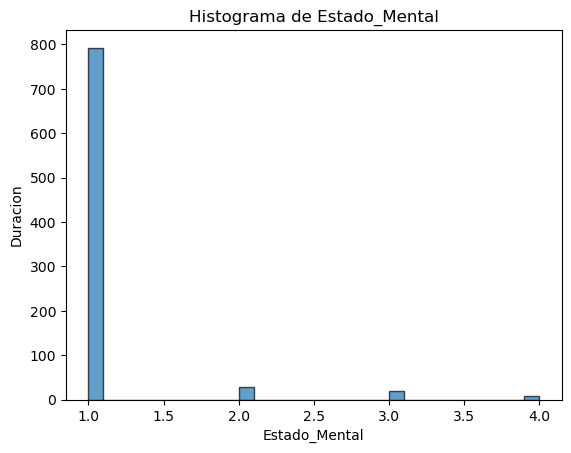

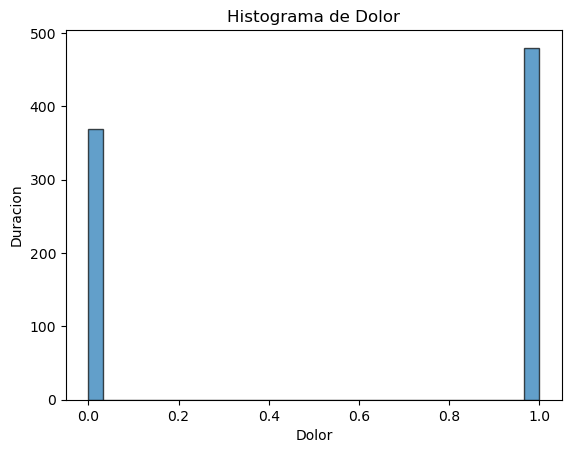

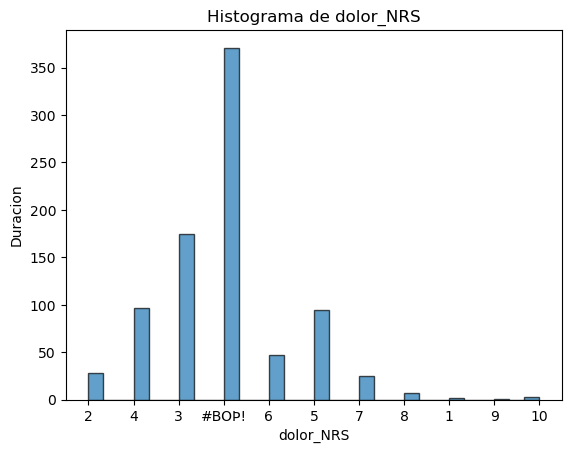

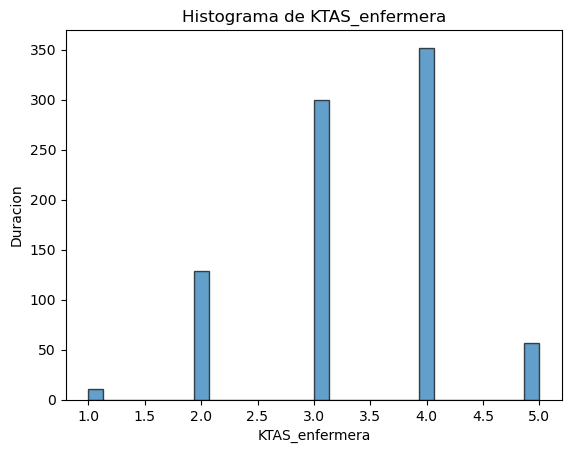

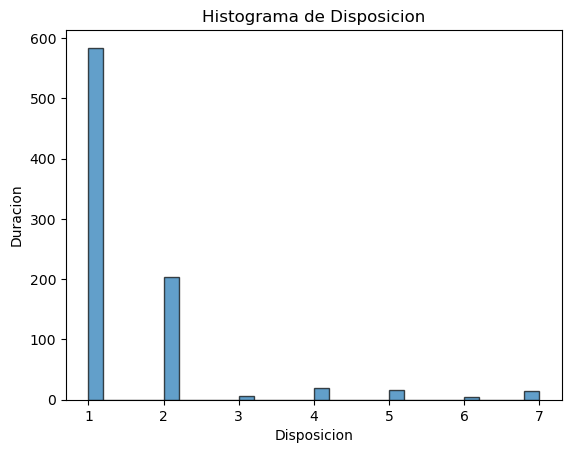

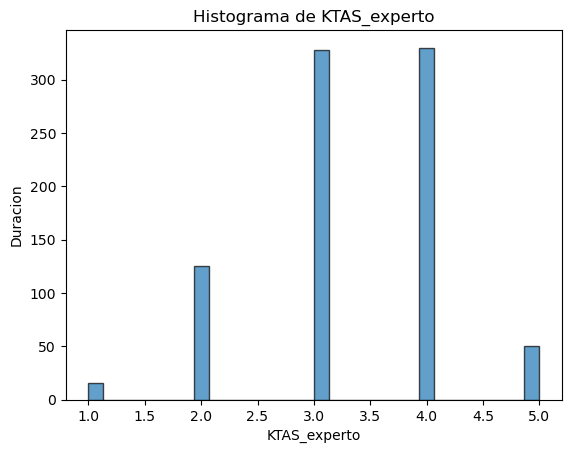

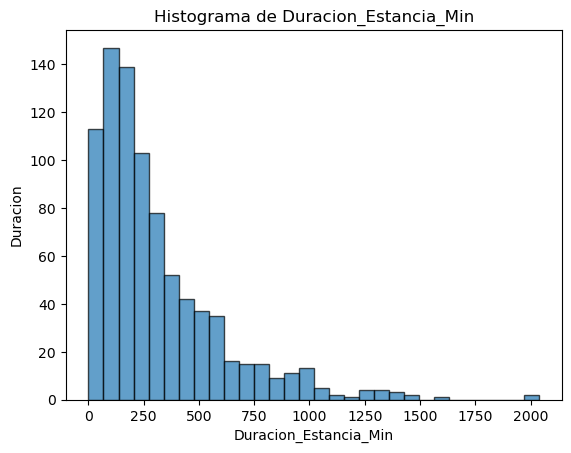

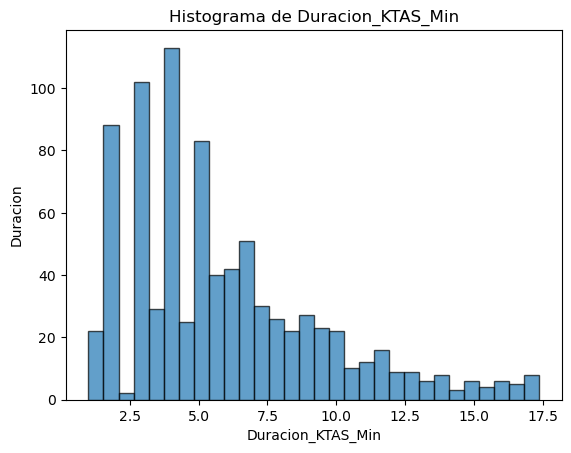

In [125]:
for variable in numericas:
    plt.hist(prueba[variable], bins=30, edgecolor='k', alpha=0.7)
    plt.title('Histograma de ' + variable)
    plt.xlabel(variable)
    plt.ylabel('Duracion')
    plt.show()

Parámetros ajustados: n=5.0, p=0.5


C:\Users\jorgi\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


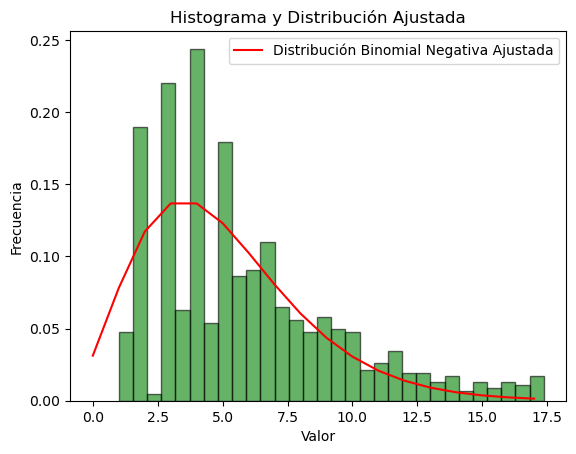

In [126]:
# Definir la función de log-verosimilitud
def negative_binomial_log_likelihood(params, data):
    n, p = params
    return -np.sum(stats.nbinom.logpmf(data, n, p))

# Estimar parámetros usando scipy.optimize
initial_guess = [5, 0.5]  # Valores iniciales para n y p
result = optimize.minimize(negative_binomial_log_likelihood, initial_guess, args=(prueba["Duracion_KTAS_Min"],), bounds=[(1, None), (0.01, 0.99)])

n_est, p_est = result.x
print(f"Parámetros ajustados: n={n_est}, p={p_est}")

# Graficar los datos y la distribución ajustada
x = np.arange(0, prueba["Duracion_KTAS_Min"].max())
pdf_fitted = stats.nbinom.pmf(x, n_est, p_est)


plt.hist(prueba["Duracion_KTAS_Min"], bins=30, density=True, alpha=0.6, color='g', edgecolor='black')
plt.plot(x, pdf_fitted, 'r-', label='Distribución Binomial Negativa Ajustada')
plt.title('Histograma y Distribución Ajustada')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

Parámetros ajustados: shape=0.610706453412977, loc=0, scale=4.9936647438455735


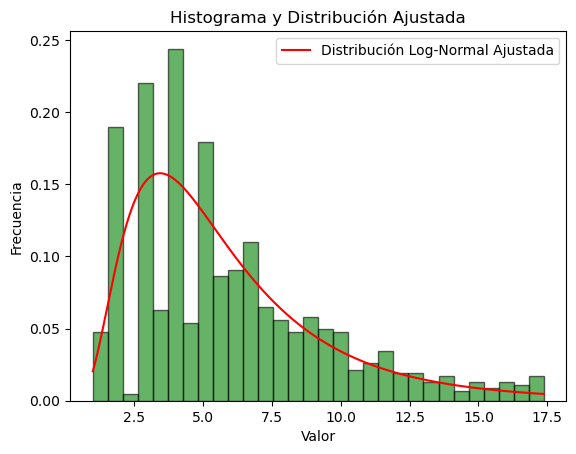

In [127]:
shape, loc, scale = stats.lognorm.fit(prueba["Duracion_KTAS_Min"], floc=0)

print(f"Parámetros ajustados: shape={shape}, loc={loc}, scale={scale}")

# Graficar el histograma de los datos y la distribución ajustada
x = np.linspace(min(prueba["Duracion_KTAS_Min"]), max(prueba["Duracion_KTAS_Min"]), 805)
pdf_fitted = stats.lognorm.pdf(x, shape, loc, scale)

plt.hist(prueba["Duracion_KTAS_Min"], bins=30, density=True, alpha=0.6, color='g', edgecolor='black')
plt.plot(x, pdf_fitted, 'r-', label='Distribución Log-Normal Ajustada')
plt.title('Histograma y Distribución Ajustada')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

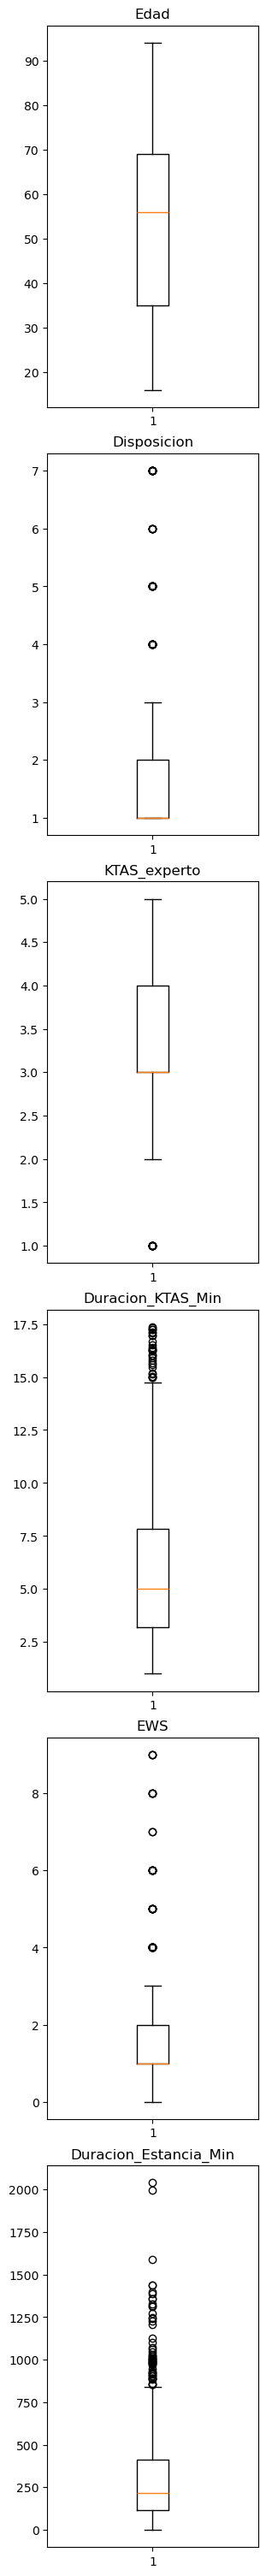

In [128]:
candidatas2=candidatas+["Duracion_Estancia_Min"]
fig, ax = plt.subplots(len(candidatas2), 1, layout="constrained", figsize=(3,30))
for i in range(len(candidatas2)):
    ax[i].boxplot(prueba[candidatas2[i]])
    ax[i].set_title(candidatas2[i])

<Axes: xlabel='Duracion_Estancia_Min'>

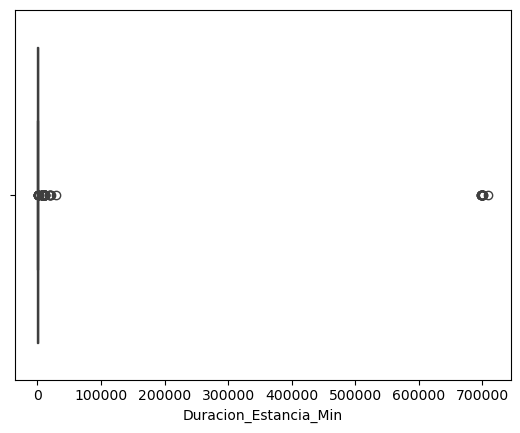

In [129]:
sns.boxplot(datos, x="Duracion_Estancia_Min")

(849, 24)

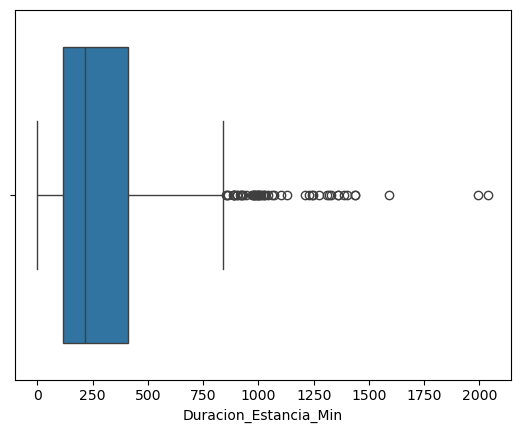

In [130]:

sns.boxplot(prueba, x="Duracion_Estancia_Min")
prueba.shape

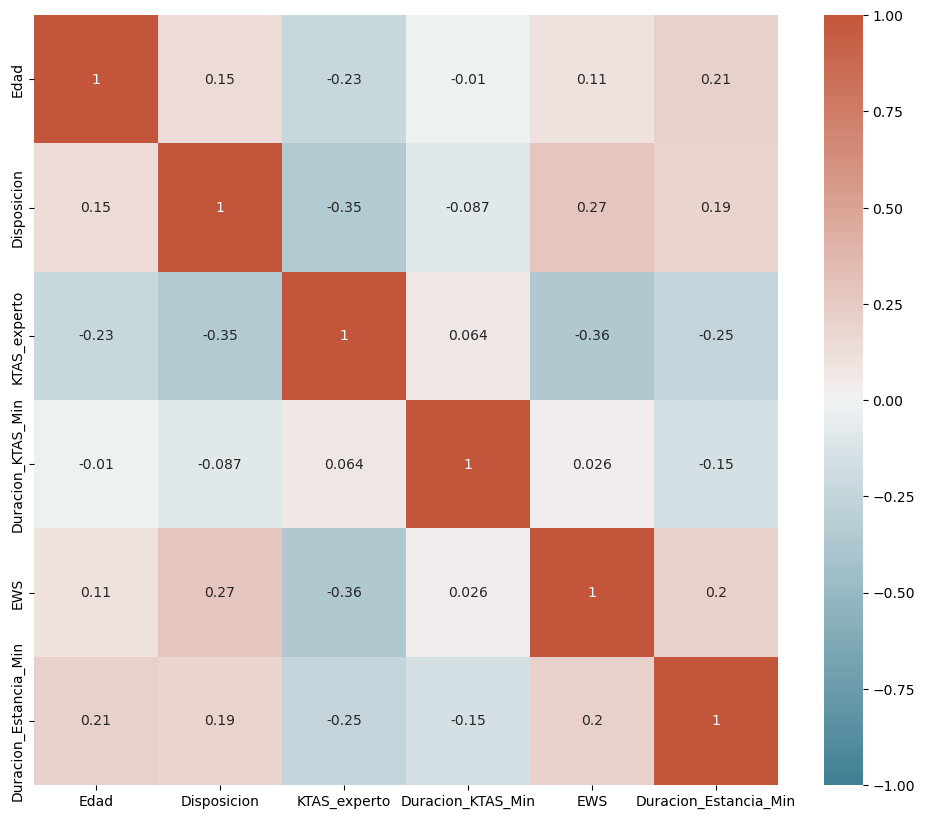

In [131]:
plt.figure(figsize=(12, 10))
# Crear una paleta de colores divergente con el color blanco en el centro
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Crear el heatmap con la paleta personalizada
sns.heatmap(
    prueba[candidatas + ['Duracion_Estancia_Min']].corr(),
    cmap=cmap,
    vmin=-1, vmax=1,
    annot=True
)

plt.show()

### 2.2. Búsqueda de relaciones entre las variables de entrada

**Importante:** La regresión lineal asume que sus variables de entrada no se encuentran altamente correlacionados.

<Axes: >

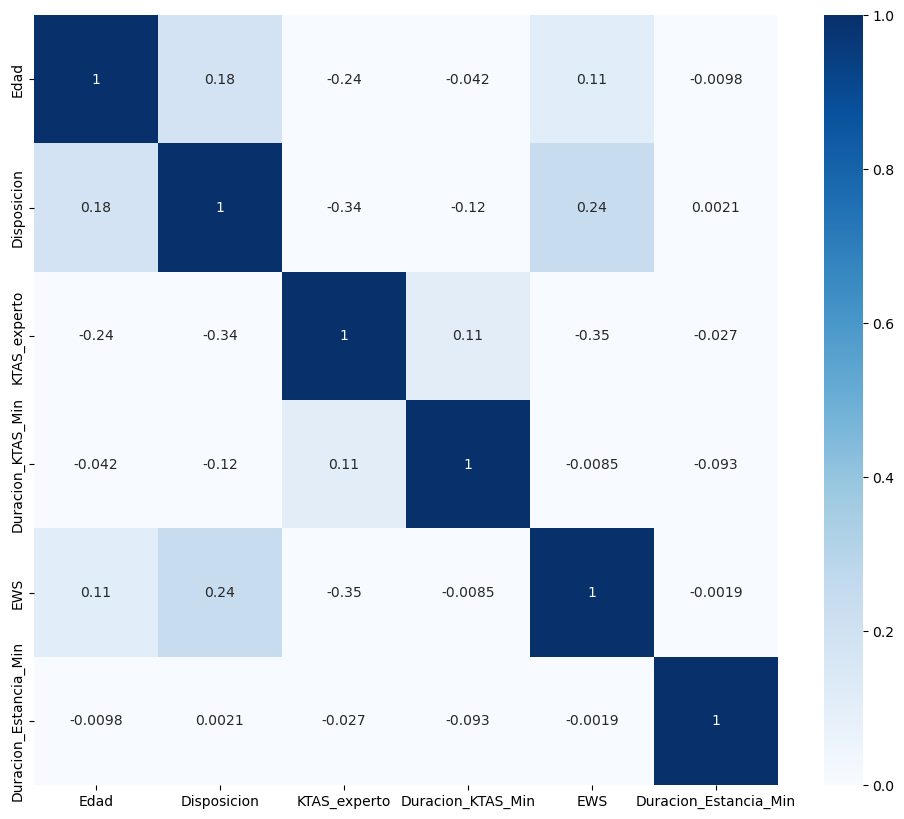

In [133]:
plt.figure(figsize=(12, 10))
sns.heatmap(datos[candidatas+['Duracion_Estancia_Min']].corr(), cmap="Blues", vmin=0, vmax=1, annot = True)

## 3. Preparación de datos

In [135]:
datos=datos[datos["Duracion_Estancia_Min"]<=4000]
datos["Disposicion"]=datos["Disposicion"]/7
datos["KTAS_experto"]=datos["KTAS_experto"]/5
datos["Estado_Mental"]=datos["Estado_Mental"]/4

### 3.1. Relacionado con la calidad de los datos

In [137]:
# Se eliminan los registros totalmente duplicados
datos = datos.dropna(subset=["Duracion_Estancia_Min"]+candidatas)

In [138]:
datos.shape
total_rows = datos.shape[0]
total_rows

849

In [139]:
datos[["Duracion_Estancia_Min"]+candidatas].isnull().sum() / datos.shape[0]

Duracion_Estancia_Min    0.0
Edad                     0.0
Disposicion              0.0
KTAS_experto             0.0
Duracion_KTAS_Min        0.0
EWS                      0.0
dtype: float64

In [140]:
datos[datos[["Duracion_Estancia_Min"]+candidatas] == '#BOÞ!'][["Duracion_Estancia_Min"]+candidatas].count()/ datos.shape[0]

Duracion_Estancia_Min    0.0
Edad                     0.0
Disposicion              0.0
KTAS_experto             0.0
Duracion_KTAS_Min        0.0
EWS                      0.0
dtype: float64

In [141]:
datos.loc[datos.duplicated(subset=candidatas, keep=False)].head(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS
9,2,2,27,2,1,LLQ pain,0.25,1,3,130.0,...,97.0,4,Unspecified abdominal pain,0.142857,0.8,0,493,2.00,0,1
20,1,2,78,3,1,dizziness,0.25,0,#BOÞ!,132.0,...,NaN,3,Dizziness,0.142857,0.6,0,129,5.38,0,2
36,2,1,33,3,1,Vaginal Bleeding,0.25,1,6,160.0,...,100.0,4,"Abnormal uterine and vaginal bleeding, unspeci...",0.142857,0.8,0,191,3.00,0,1
55,2,2,40,3,1,"Leg pain, NOS",0.25,1,3,110.0,...,NaN,5,Complex regional pain syndrome type II,0.142857,1.0,0,60,2.00,0,1
70,2,1,77,3,1,fever,0.25,1,3,120.0,...,96.0,4,"Infective arthritis NOS, pelvic region and thigh",0.285714,0.8,0,205,3.00,0,1


In [142]:
duplicated_rows = datos.loc[datos.duplicated(subset=candidatas, keep=False)].shape[0]
duplicated_rows

85

In [143]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 10.0118%


In [144]:
datos.loc[datos.duplicated(subset=candidatas+["Duracion_Estancia_Min"], keep=False)].tail(4)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS
996,1,1,27,3,1,Suicidal Attempt,0.25,0,#BOÞ!,110.0,...,NaN,3,Suicide tendency,0.285714,0.6,0,442,7.42,0,1
997,1,2,54,2,1,"pain, chest",0.25,1,6,159.0,...,NaN,2,Gastroesophageal reflux disease,0.142857,0.4,0,214,4.95,0,1
998,1,1,19,3,1,eye discomfort,0.25,0,#BOÞ!,132.0,...,NaN,4,Corneal erosion,0.142857,0.8,0,50,3.45,0,1
999,1,2,29,3,1,"pain, abdominal",0.25,1,6,137.0,...,NaN,3,Allergic reaction,0.142857,0.6,0,116,5.97,0,1


In [145]:
duplicated_rows = datos.loc[datos.duplicated(subset=candidatas+["Duracion_Estancia_Min"], keep=False)].shape[0]
duplicated_rows

59

In [146]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 6.9494%


In [147]:
datos.drop_duplicates(subset=candidatas, inplace=True)
datos.drop_duplicates(subset=candidatas+["Duracion_Estancia_Min"], inplace=True)

In [148]:
datos.shape

(805, 24)

Train: 257.0383076561674
Test: 295.27650236713237


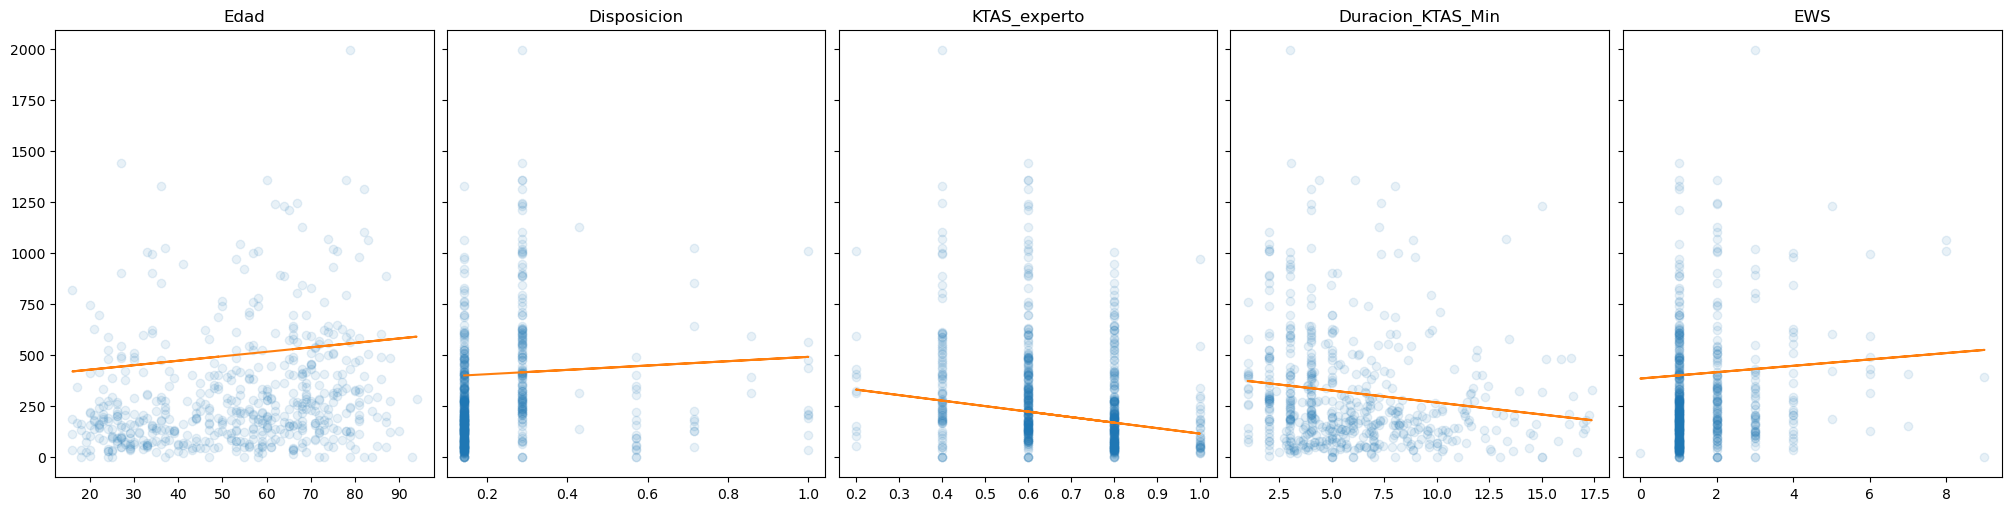

In [149]:
X_train, X_test, y_train, y_test = train_test_split(datos[candidatas], datos["Duracion_Estancia_Min"], test_size=0.3, random_state=1)
X_train.shape, y_train.shape
X_test.shape, y_test.shape
regression = LinearRegression()
regression.fit(X_train, y_train)
pd.DataFrame({"columns": candidatas, "coef": regression.coef_})
f, axs = plt.subplots(1, len(candidatas), sharey=True, figsize=(20, 5), layout="constrained")

for i in range(len(candidatas)):
    col = candidatas[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))


In [150]:
datos.sample(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS
900,1,1,56,3,1,voiding difficulty,0.25,0,#BOÞ!,107.0,...,NaN,4,Acute urinary retension,0.142857,0.8,0,52,10.02,0,1
319,2,2,53,2,1,dizziness,0.25,0,#BOÞ!,100.0,...,99.0,3,Orthostatic hypotension,0.142857,0.6,0,2040,4.00,0,2
465,2,1,70,2,1,epigastric pain,0.25,1,4,100.0,...,98.0,4,Infectious or septic colitis,0.142857,0.6,2,714,4.00,2,2
618,1,2,56,3,2,"pelvic pain, Lt",0.25,1,6,105.0,...,NaN,4,Fracture of hip closed,0.285714,0.8,0,712,10.15,0,1
915,2,1,28,3,1,Vaginal Bleeding,0.25,0,#BOÞ!,100.0,...,100.0,3,Threatened abortion,0.142857,0.6,0,375,5.00,0,3


# Procesamiento de texto

In [152]:
datos['Queja_Principal'].info()

<class 'pandas.core.series.Series'>
Index: 805 entries, 0 to 966
Series name: Queja_Principal
Non-Null Count  Dtype 
--------------  ----- 
805 non-null    object
dtypes: object(1)
memory usage: 12.6+ KB


In [153]:
textos = datos.copy()
textos['Conteo'] = [len(x) for x in textos['Queja_Principal']]
#textos['Moda'] =
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Queja_Principal']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Queja_Principal']]


In [154]:
textos

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS,Conteo,Max,Min
0,2,2,49,2,1,ant. chest pain,0.25,1,2,150.0,...,0.285714,0.4,0,1591,2.00,0,1,15,5,4
1,2,2,30,2,1,headache,0.25,1,4,140.0,...,1.000000,0.6,0,211,3.00,0,1,8,8,8
2,2,1,61,3,2,ant. chest pain,0.25,1,3,100.0,...,0.142857,0.8,0,119,2.00,0,2,15,5,4
3,2,2,61,3,1,headache,0.25,1,4,120.0,...,0.142857,0.6,4,414,2.00,2,1,8,8,8
4,1,2,67,3,1,fever & chill,0.25,0,#BOÞ!,143.0,...,0.142857,0.4,1,267,3.60,2,4,13,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,2,2,64,3,1,dysarthria,0.25,0,#BOÞ!,130.0,...,0.285714,0.6,0,356,2.00,0,1,10,10,10
963,2,1,70,3,1,DZ - Dizziness,0.25,0,#BOÞ!,180.0,...,0.142857,0.4,0,456,4.00,0,1,14,9,1
964,2,1,75,3,1,dysarthria,0.25,0,#BOÞ!,120.0,...,0.285714,0.6,0,278,2.00,0,1,10,10,10
965,1,1,26,3,2,sexual violence,0.25,0,#BOÞ!,117.0,...,0.142857,0.8,0,199,11.32,0,1,15,8,6


In [155]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word:  # Verifica que la palabra no sea None o una cadena vacía
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = [word.lower() for word in words if word]  # Usa comprensión de listas
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = [re.sub(r'[^\w\s]', '', word) for word in words if word]  # Usa comprensión de listas
    return [word for word in new_words if word]

#def replace_numbers(words):
#    """Replace all interger occurrences in list of tokenized words with textual representation"""
#    p = inflect.engine()
#    print(words)
#    new_words = []
#    for word in words:
#        if word.isdigit():
#            new_word = p.number_to_words(word)
#            new_words.append(new_word)
#            print("if " + new_word)
#        else:
#            new_words.append(word)
#    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    stop_words = set(stopwords.words('english'))  # Usa un set para búsquedas más rápidas
    filtered_words = [word for word in words if word not in stop_words]
    return filtered_words

def preprocessing(words):
    words = to_lowercase(words)
#   words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [156]:
datos['Queja_Principal'] = datos['Queja_Principal'].apply(contractions.fix)

In [157]:
datos['words'] = datos['Queja_Principal'].apply(word_tokenize)
datos.head()

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS,words
0,2,2,49,2,1,ant. chest pain,0.25,1,2,150.0,...,2,Ischaemic chest pain,0.285714,0.4,0,1591,2.0,0,1,"[ant, ., chest, pain]"
1,2,2,30,2,1,headache,0.25,1,4,140.0,...,3,"Subarachnoid haemorrhage, unspecified",1.000000,0.6,0,211,3.0,0,1,[headache]
2,2,1,61,3,2,ant. chest pain,0.25,1,3,100.0,...,4,Contusion of front wall of thorax,0.142857,0.8,0,119,2.0,0,2,"[ant, ., chest, pain]"
3,2,2,61,3,1,headache,0.25,1,4,120.0,...,4,Headache,0.142857,0.6,4,414,2.0,2,1,[headache]
4,1,2,67,3,1,fever & chill,0.25,0,#BOÞ!,143.0,...,4,Fever,0.142857,0.4,1,267,3.6,2,4,"[fever, &, chill]"


In [158]:
datos['words'].dropna()

0      [ant, ., chest, pain]
1                 [headache]
2      [ant, ., chest, pain]
3                 [headache]
4          [fever, &, chill]
               ...          
962             [dysarthria]
963       [DZ, -, Dizziness]
964             [dysarthria]
965       [sexual, violence]
966              [dizziness]
Name: words, Length: 805, dtype: object

In [159]:
datos.shape

(805, 25)

In [160]:
datos['words'].info()

<class 'pandas.core.series.Series'>
Index: 805 entries, 0 to 966
Series name: words
Non-Null Count  Dtype 
--------------  ----- 
805 non-null    object
dtypes: object(1)
memory usage: 12.6+ KB


In [161]:
datos['words1']=datos['words'].apply(preprocessing)

datos.head()

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS,words,words1
0,2,2,49,2,1,ant. chest pain,0.25,1,2,150.0,...,Ischaemic chest pain,0.285714,0.4,0,1591,2.0,0,1,"[ant, ., chest, pain]","[ant, chest, pain]"
1,2,2,30,2,1,headache,0.25,1,4,140.0,...,"Subarachnoid haemorrhage, unspecified",1.000000,0.6,0,211,3.0,0,1,[headache],[headache]
2,2,1,61,3,2,ant. chest pain,0.25,1,3,100.0,...,Contusion of front wall of thorax,0.142857,0.8,0,119,2.0,0,2,"[ant, ., chest, pain]","[ant, chest, pain]"
3,2,2,61,3,1,headache,0.25,1,4,120.0,...,Headache,0.142857,0.6,4,414,2.0,2,1,[headache],[headache]
4,1,2,67,3,1,fever & chill,0.25,0,#BOÞ!,143.0,...,Fever,0.142857,0.4,1,267,3.6,2,4,"[fever, &, chill]","[fever, chill]"


In [162]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = [stemmer.stem(word) for word in words]
    return stems
    

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lems = [lemmatizer.lemmatize(word) for word in words]
    return lems

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

datos['words'] = datos['words1'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
datos

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS,words,words1
0,2,2,49,2,1,ant. chest pain,0.25,1,2,150.0,...,Ischaemic chest pain,0.285714,0.4,0,1591,2.00,0,1,"[ant, chest, pain, ant, chest, pain]","[ant, chest, pain]"
1,2,2,30,2,1,headache,0.25,1,4,140.0,...,"Subarachnoid haemorrhage, unspecified",1.000000,0.6,0,211,3.00,0,1,"[headach, headache]",[headache]
2,2,1,61,3,2,ant. chest pain,0.25,1,3,100.0,...,Contusion of front wall of thorax,0.142857,0.8,0,119,2.00,0,2,"[ant, chest, pain, ant, chest, pain]","[ant, chest, pain]"
3,2,2,61,3,1,headache,0.25,1,4,120.0,...,Headache,0.142857,0.6,4,414,2.00,2,1,"[headach, headache]",[headache]
4,1,2,67,3,1,fever & chill,0.25,0,#BOÞ!,143.0,...,Fever,0.142857,0.4,1,267,3.60,2,4,"[fev, chil, fever, chill]","[fever, chill]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,2,2,64,3,1,dysarthria,0.25,0,#BOÞ!,130.0,...,Cerebral infarction due to thrombosis of middl...,0.285714,0.6,0,356,2.00,0,1,"[dysarthr, dysarthria]",[dysarthria]
963,2,1,70,3,1,DZ - Dizziness,0.25,0,#BOÞ!,180.0,...,Vestibular neuronitis,0.142857,0.4,0,456,4.00,0,1,"[dz, dizzy, dz, dizziness]","[dz, dizziness]"
964,2,1,75,3,1,dysarthria,0.25,0,#BOÞ!,120.0,...,Cerebrovascular accident NOS,0.285714,0.6,0,278,2.00,0,1,"[dysarthr, dysarthria]",[dysarthria]
965,1,1,26,3,2,sexual violence,0.25,0,#BOÞ!,117.0,...,Sexual abuse of adult,0.142857,0.8,0,199,11.32,0,1,"[sex, viol, sexual, violence]","[sexual, violence]"


In [163]:
datos['words'] = datos['words1'].apply(lambda x: ' '.join(map(str, x)))
datos

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS,words,words1
0,2,2,49,2,1,ant. chest pain,0.25,1,2,150.0,...,Ischaemic chest pain,0.285714,0.4,0,1591,2.00,0,1,ant chest pain,"[ant, chest, pain]"
1,2,2,30,2,1,headache,0.25,1,4,140.0,...,"Subarachnoid haemorrhage, unspecified",1.000000,0.6,0,211,3.00,0,1,headache,[headache]
2,2,1,61,3,2,ant. chest pain,0.25,1,3,100.0,...,Contusion of front wall of thorax,0.142857,0.8,0,119,2.00,0,2,ant chest pain,"[ant, chest, pain]"
3,2,2,61,3,1,headache,0.25,1,4,120.0,...,Headache,0.142857,0.6,4,414,2.00,2,1,headache,[headache]
4,1,2,67,3,1,fever & chill,0.25,0,#BOÞ!,143.0,...,Fever,0.142857,0.4,1,267,3.60,2,4,fever chill,"[fever, chill]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,2,2,64,3,1,dysarthria,0.25,0,#BOÞ!,130.0,...,Cerebral infarction due to thrombosis of middl...,0.285714,0.6,0,356,2.00,0,1,dysarthria,[dysarthria]
963,2,1,70,3,1,DZ - Dizziness,0.25,0,#BOÞ!,180.0,...,Vestibular neuronitis,0.142857,0.4,0,456,4.00,0,1,dz dizziness,"[dz, dizziness]"
964,2,1,75,3,1,dysarthria,0.25,0,#BOÞ!,120.0,...,Cerebrovascular accident NOS,0.285714,0.6,0,278,2.00,0,1,dysarthria,[dysarthria]
965,1,1,26,3,2,sexual violence,0.25,0,#BOÞ!,117.0,...,Sexual abuse of adult,0.142857,0.8,0,199,11.32,0,1,sexual violence,"[sexual, violence]"


In [164]:
X_data, y_data = datos['words'],datos['Duracion_Estancia_Min']
y_data
X_data

0       ant chest pain
1             headache
2       ant chest pain
3             headache
4          fever chill
            ...       
962         dysarthria
963       dz dizziness
964         dysarthria
965    sexual violence
966          dizziness
Name: words, Length: 805, dtype: object

In [165]:
dummy = CountVectorizer(binary=True)
X_dummy = dummy.fit_transform(X_data)  # X_data es tu lista de textos
print(X_dummy.shape)  # (805, 412)

# Paso 2: Convertir a DataFrame (esto es opcional si solo quieres ver los datos en formato de tabla)
X_dense = X_dummy.toarray()
X_df = pd.DataFrame(X_dense, columns=dummy.get_feature_names_out())
print(X_df.head())
print(X_df.shape)  # Debe coincidir con (805, 412)

# Paso 3: Aplicar TF-IDF usando TfidfTransformer
tt = TfidfTransformer(norm='l2', use_idf=True)
tt_matrix = tt.fit_transform(X_dummy)  # Usa X_dummy directamente

# Paso 4: Convertir a una matriz densa si es necesario para inspección o para usarla en otro proceso
tt_matrix_dense = tt_matrix.toarray()

# Paso 5: Crear DataFrame con la matriz TF-IDF
vocab = dummy.get_feature_names_out()
tt_df = pd.DataFrame(np.round(tt_matrix_dense, 2), columns=vocab)

print(tt_df.head())

tt_df.describe()

(805, 263)
   abd  abdomen  abdominal  abnormal  abuse  activity  acuity  acute  adult  \
0    0        0          0         0      0         0       0      0      0   
1    0        0          0         0      0         0       0      0      0   
2    0        0          0         0      0         0       0      0      0   
3    0        0          0         0      0         0       0      0      0   
4    0        0          0         0      0         0       0      0      0   

   alcohol  ...  visual  voice  voiding  vomiting  wall  weakness  whirling  \
0        0  ...       0      0        0         0     0         0         0   
1        0  ...       0      0        0         0     0         0         0   
2        0  ...       0      0        0         0     0         0         0   
3        0  ...       0      0        0         0     0         0         0   
4        0  ...       0      0        0         0     0         0         0   

   wound  wrist  wyou  
0      0      0

,abd,abdomen,abdominal,abnormal,abuse,activity,acuity,acute,adult,alcohol,...,visual,voice,voiding,vomiting,wall,weakness,whirling,wound,wrist,wyou
count,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,...,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000
mean,0.066571,0.008634,0.017056,0.000882,0.000745,0.001640,0.000733,0.004845,0.000745,0.001267,...,0.001540,0.000882,0.006099,0.016149,0.001801,0.021888,0.002199,0.018075,0.005665,0.000882
std,0.224847,0.086934,0.110196,0.025024,0.021147,0.032971,0.020795,0.061350,0.021147,0.025405,...,0.031081,0.025024,0.065775,0.126127,0.036116,0.115217,0.035973,0.110626,0.065621,0.025024
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.850000,0.930000,0.910000,0.710000,0.600000,0.710000,0.590000,0.800000,0.600000,0.510000,...,0.690000,0.710000,0.930000,1.000000,0.730000,1.000000,0.590000,0.700000,0.810000,0.710000


In [166]:
X_train, X_test, y_train, y_test = train_test_split(tt_df, y_data, test_size=0.3, random_state=42)

In [167]:
regressor = LinearRegression()

# Entrenar el modelo
regressor.fit(X_train, y_train)

LinearRegression()

In [168]:
print("Train:", np.sqrt(mean_squared_error(y_train, regressor.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regressor.predict(X_test))))

Train: 256.0436178059871
Test: 3941261660155843.0


In [169]:
coefficients_df = pd.DataFrame({
    "columns": tt_df.columns,  # Nombres de las características (palabras del vocabulario)
    "coef": regressor.coef_   # Coeficientes del modelo de regresión lineal
})

print(coefficients_df)

       columns          coef
0          abd  8.899139e+02
1      abdomen  3.442610e+02
2    abdominal  3.148533e+02
3     abnormal  4.052942e+16
4        abuse -5.988753e+16
..         ...           ...
258   weakness  1.050000e+02
259   whirling -9.809959e+15
260      wound -1.440000e+02
261      wrist  5.300000e+02
262       wyou  1.119165e+16

[263 rows x 2 columns]


In [173]:
quejas=pd.DataFrame(regressor.predict(tt_df))
quejas=quejas.rename(columns={0:'Quejas'})
datos["Quejas"]=quejas["Quejas"]
nuevo=["Quejas"]+candidatas
print(datos.value_counts())
print(pd.concat([datos[candidatas], quejas], axis=1))
X_train, X_test, y_train, y_test = train_test_split(datos[nuevo], datos["Duracion_Estancia_Min"], test_size=0.3, random_state=1)
X_train.shape, y_train.shape
X_test.shape, y_test.shape
regression = LinearRegression()
regression.fit(X_train, y_train)
pd.DataFrame({"columns": candidatas+["Quejas"], "coef": regression.coef_})
f, axs = plt.subplots(1, len(nuevo), sharey=True, figsize=(20, 5), layout="constrained")

for i in range(len(nuevo)):
    col = nuevo[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

TypeError: unhashable type: 'list'